In [97]:
import numpy as np

import matplotlib.pyplot as plt

import shap

import lightgbm as lgb

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification

from sklearn.inspection import permutation_importance

In [98]:
# Generate dataset

X,y = make_classification(n_samples=5000, n_features=10, random_state=42)

In [99]:
# Split the Data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [100]:
X_train.shape


(4000, 10)

In [101]:
# Train LightGBM model

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test)

In [102]:
params = {

    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'learning_rate' : 0.05,
    'num_leaves' : 31

}

In [103]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=200,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=False)
    ]

    )

[LightGBM] [Info] Number of positive: 2017, number of negative: 1983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504250 -> initscore=0.017000
[LightGBM] [Info] Start training from score 0.017000
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.204884


In [104]:
# Calculate SHAP values

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

/opt/anaconda3/envs/masterxml/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


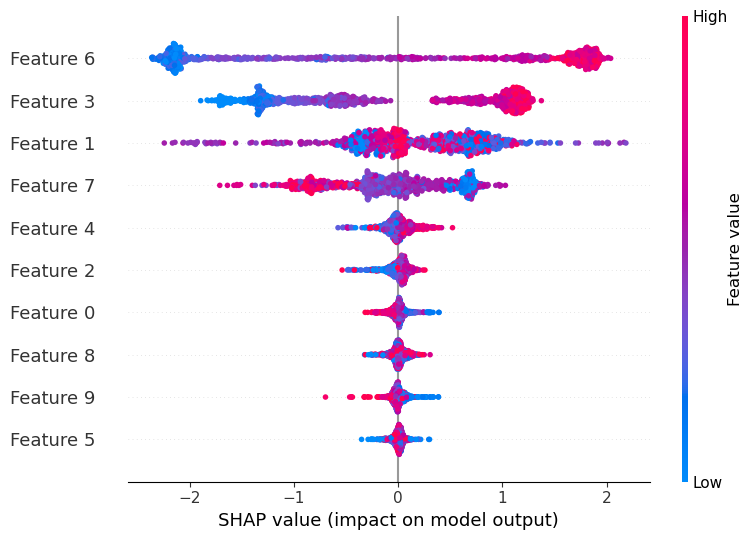

In [105]:
# Feature importance plot

shap.summary_plot(shap_values,X_test, feature_names = [f'Feature {i}' for i in range (X.shape[1])])

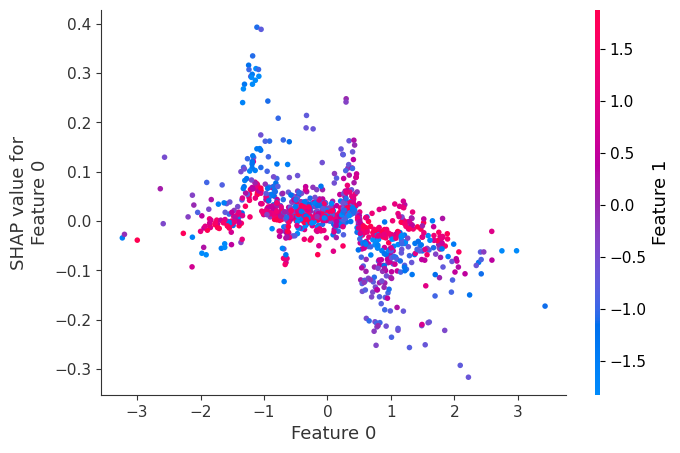

In [106]:
# SHAP Dependence Plot for Feature 0

shap.dependence_plot(0, shap_values, X_test, feature_names=[f'Feature {i}' for i in range(X_test.shape[1])])


Permutation importance measures how randomly shuffling a feature affects model accuracy.
Example: Using Permutation Importance

Permutation Feature Importance

Instead of passing model directly, you should use the scikit-learn wrapper for LightGBM, LGBMClassifier or LGBMRegressor.
 The LGBM models are compatible with scikit-learn utilities like permutation_importance.

In [107]:
# Convert Booster to LGBMClassifier
lgbm_model = LGBMClassifier(**params)
lgbm_model.fit(X_train[:10], y_train[:10])  # Fit on a small subset to initialize internal structures
lgbm_model._Booster = model  # Assign trained booster

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 4, number of negative: 6
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

In [108]:
# Compute permutation importance

perm_importance = permutation_importance(lgbm_model, X_test, y_test, n_repeats=10, random_state=42)

In [109]:
# Sort by importance

sorted_idx = perm_importance.importances_mean.argsort()

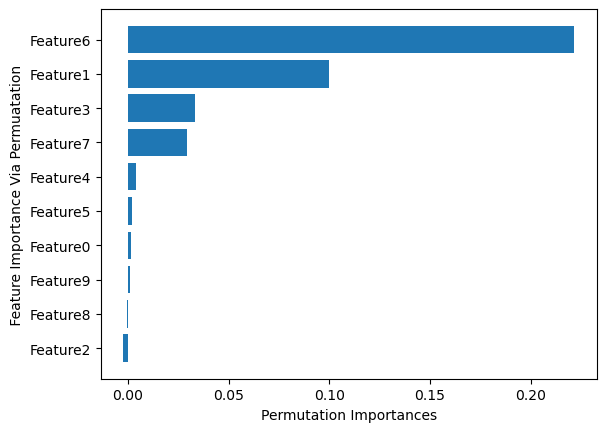

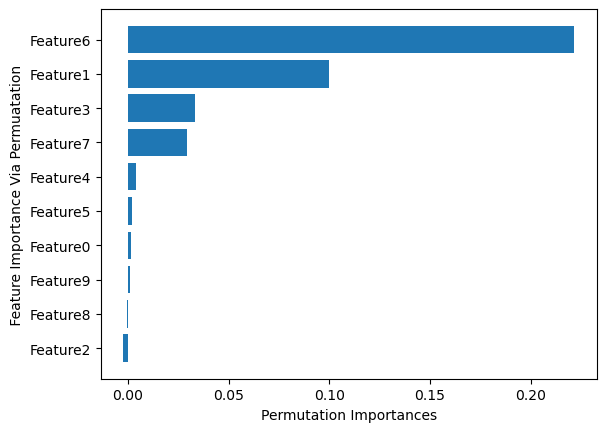

In [110]:
# Plot feature importance

plt.barh([f'Feature{i}' for  i in sorted_idx], perm_importance.importances_mean[sorted_idx])

plt.xlabel('Permutation Importances')

plt.ylabel(' Feature Importance Via Permuatation ')

plt.show(0)

Once we identify low-importance features, we can drop them to improve model performance.
Example: Dropping Low-Importance Features & Retraining

In [111]:
# Get low-importance features (bottom 20%)

low_importance_features = sorted_idx[:2]  # Selecting 2 least important features


In [112]:
X_train_reduced = np.delete(X_train, low_importance_features, axis=1)

X_test_reduced = np.delete(X_test, low_importance_features, axis=1)


In [113]:
# Retrain model

train_data_reduced = lgb.Dataset(X_train_reduced, label=y_train)

test_data_reduced = lgb.Dataset(X_test_reduced, label=y_test)

In [114]:
model_reduced = lgb.train(
    params, 
    train_data_reduced, 
    valid_sets=[test_data_reduced], 
    num_boost_round=200, 

    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=False)
    ]
  
)

[LightGBM] [Info] Number of positive: 2017, number of negative: 1983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504250 -> initscore=0.017000
[LightGBM] [Info] Start training from score 0.017000
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.204966
